mainly looking at https://github.com/ngessert/isic2019/blob/master/models.py

# start

In [1]:
class Param: pass
param = Param()

param.PRFX = 'Mel0627B1'
param.PRFX_PREP = 'MelPrp0626A2'
param.ARCH = 'efficientnet-b1'
param.SZ = 224
param.EPOCHS = 10
param.BS = 128
param.K=5; param.SEED=101; param.FLD2USE=0
param.FP16 = True

param.LR=3e-3
param.WD=0.

param.N_SAMPL = int(5e3)

param.DEBUG = True
if param.DEBUG: 
    param.EPOCHS = 1
    param.K = 2
    param.N_SAMPL = 256

DEVICE = 'cuda'; PIN_MEM = (DEVICE=='cuda'); N_WORKERS=4

param.__dict__

{'PRFX': 'Mel0627B1',
 'PRFX_PREP': 'MelPrp0626A2',
 'ARCH': 'efficientnet-b1',
 'SZ': 224,
 'EPOCHS': 1,
 'BS': 128,
 'K': 2,
 'SEED': 101,
 'FLD2USE': 0,
 'FP16': True,
 'LR': 0.003,
 'WD': 0.0,
 'N_SAMPL': 256,
 'DEBUG': True}

In [2]:
!nvidia-smi

Sat Jun 27 20:04:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   53C    P8    28W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# setup

In [3]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import random
import os, sys, gc
import datetime
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score as roc_auc

# https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/162#issuecomment-491115265
from PIL import ImageFile; ImageFile.LOAD_TRUNCATED_IMAGES = True

def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

import torch
device=torch.device(DEVICE)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

from efficientnet_pytorch import EfficientNet

from apex import amp

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(param.SEED)



p_out=f'../output/{param.PRFX}'; Path(p_out).mkdir(exist_ok=True,parents=True)
p_cmp = '../input/siim-isic-melanoma-classification'



# prep

In [4]:
p_prp = f'../output/{param.PRFX_PREP}'
dftrn = pd.read_csv(f'{p_prp}/train_all.csv') 
print(dftrn.shape)

set_seed(param.SEED); dftrn = dftrn.sample(frac=1.)

if param.N_SAMPL is not None: dftrn = dftrn.head(param.N_SAMPL)
    
display(dftrn.head(2))
display(dftrn.shape)
display(dftrn.source.value_counts())
display(dftrn.groupby('source').target.mean())

(58457, 4)


,source,im_pth,patient_id,target
24437,20,../input/siim-isic-melanoma-classification/jpe...,IP_4021847,0.0
57432,19,../input/andrewmvd--isic-2019/ISIC_2019_Traini...,BCN_0004730,1.0


(256, 4)

20    146
19    110
Name: source, dtype: int64

source
19    0.154545
20    0.013699
Name: target, dtype: float64

## folds

In [5]:
idx_nopid=np.where(dftrn.patient_id.isna())[0]
print(len(idx_nopid))
dftrn['patient_id'].iloc[idx_nopid]=[f'Nan_{i}' for i in range(len(idx_nopid))]
assert dftrn.patient_id.isna().mean()==0

9


In [6]:
set_seed(param.SEED)
kf = GroupKFold(n_splits=param.K)
fld2trvl={fld:(tr,vl) for fld,(tr,vl) in enumerate(kf.split(dftrn, groups=dftrn.patient_id))}

for fld, (tr, vl) in fld2trvl.items():
    print(fld, len(tr), len(vl))
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    assert set(dftr.patient_id)&set(dfvl.patient_id)==set()
for fld, (tr, vl) in fld2trvl.items():
    dftr=dftrn.iloc[tr]
    display(dftr.target.value_counts()/len(tr))
for fld, (tr, vl) in fld2trvl.items():
    dftr=dftrn.iloc[tr]
    display(dftr.source.value_counts())


0 128 128
1 128 128


0.0    0.914062
1.0    0.085938
Name: target, dtype: float64

0.0    0.9375
1.0    0.0625
Name: target, dtype: float64

20    72
19    56
Name: source, dtype: int64

20    74
19    54
Name: source, dtype: int64

# dataset

In [7]:
class MelDataset(Dataset):
    def __init__(self, df, istrn=True):
        self.df = df
        self.istrn = istrn
        self.composed = transforms.Compose([
            transforms.RandomResizedCrop(param.SZ),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])    
    def __getitem__(self, i):
        x = Image.open(self.df.im_pth.values[i]) #self.imgs[i]
        x = self.composed(x)
        if self.istrn:
            y = self.df.target.values[i]
            return x, y
        else:
            return (x,)
    
    def __len__(self):
        return len(self.df)    

# model

In [8]:
def mkmdl(): return EfficientNet.from_pretrained(param.ARCH, num_classes=1)

# train

In [16]:
tr,vl=fld2trvl[param.FLD2USE]
dftr=dftrn.iloc[tr]
dfvl=dftrn.iloc[vl]
ystr=dftr.target.values
ysvl=dfvl.target.values
print(len(dftr), len(dfvl))
dstr = MelDataset(dftr)
dsvl = MelDataset(dfvl)
print(len(dstr), len(dsvl))
dltr = DataLoader(dstr, batch_size=param.BS,   shuffle=True,  num_workers=N_WORKERS, pin_memory=PIN_MEM)
dlvl = DataLoader(dsvl, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
print(len(dltr), len(dlvl))
lendl=len(dltr)

128 128
128 128
1 1


In [39]:
def evaluate(model, dl):
    model.eval()
    prd = []
    y = []
    for step, dat in enumerate(dl):
        xb, yb = (o.to(device) for o in dat)
        with torch.no_grad(): prdb = model(xb)
        prd.append(prdb.cpu().detach().numpy())
        y.append(yb.cpu().detach().numpy())
    prd = np.concatenate(prd)    
    y = np.concatenate(y)    
    lss = F.binary_cross_entropy_with_logits(torch.tensor(prd),torch.tensor(y).unsqueeze(1)).item()
    scr = roc_auc(y, prd)
    return lss, scr, y, prd

In [18]:
mdl = mkmdl()
mdl = mdl.to(device)

# opt = optim.SGD(mdl.parameters(), lr=param.LR, momentum=param.MOMENTUM, weight_decay=param.WD)
opt = optim.Adam(mdl.parameters(), lr=param.LR, weight_decay=param.WD)
# schdl = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=PLTFACTOR, patience=PATIENCE, min_lr=MIN_LR, verbose=True)

mdl, opt = amp.initialize(mdl, opt, opt_level='O1', verbosity=0)
mdl.zero_grad()


Loaded pretrained weights for efficientnet-b1


## run train

In [19]:
stats = {
    'lss': {'tr':[],'vl':[]},
    'scr': {'tr':[],'vl':[]},
}
oof = {'y':[], 'prd':[]}
best_scr = float('-inf')
best_epc = -1
for epc in range(param.EPOCHS):
    prdtr_ep=[]
    ytr_ep=[]
    for step, dat in enumerate(dltr):
        mdl.train()
        xb,yb=(o.to(device) for o in dat)
        yb = yb.unsqueeze(1)
        prdb = mdl(xb)
        loss = F.binary_cross_entropy_with_logits(prdb, yb)
        if param.FP16:
            with amp.scale_loss(loss, opt) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        if param.FP16:
            torch.nn.utils.clip_grad_norm_(amp.master_params(opt), 1)
        else:
            torch.nn.utils.clip_grad_norm_(mdl.parameters(), 1)
        opt.step()
        opt.zero_grad()
        prdtr_ep.append(prdb.cpu().detach().numpy())
        ytr_ep.append(yb.cpu().detach().numpy())
        if step%1000==0: print(dtnow(), f'ep {epc} step {step}/{lendl}')
    
    prdtr_ep = np.concatenate(prdtr_ep)
    ytr_ep = np.concatenate(ytr_ep)    
    lss_tr_ep = F.binary_cross_entropy_with_logits(torch.tensor(prdtr_ep),torch.tensor(ytr_ep)).item()
    scr_tr_ep = roc_auc(ytr_ep, prdtr_ep)
    stats['lss']['tr'].append(lss_tr_ep)
    stats['scr']['tr'].append(scr_tr_ep)
    
    lss_vl_ep, scr_vl_ep, yvl_ep, prdvl_ep = evaluate(mdl, dlvl)
    stats['lss']['vl'].append(lss_vl_ep)
    stats['scr']['vl'].append(scr_vl_ep)
    oof['y'].append(yvl_ep)
    oof['prd'].append(prdvl_ep)
    
    print(dtnow(), f'ep {epc}: lss_tr {lss_tr_ep:.3f}; lss_vl {lss_vl_ep:.3f}; scr_tr {scr_tr_ep:.3f}; scr_vl {scr_vl_ep:.3f}; ')
    
    if scr_vl_ep>best_scr:
        print(f'better scr {best_scr:.3f} -> {scr_vl_ep:.3f}')
        best_scr = scr_vl_ep
        best_epc = epc
        if not param.DEBUG: torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{param.FLD2USE}_best.p')
    if not param.DEBUG: torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{param.FLD2USE}_epc_{epc}.p')
        
#     schdl.step(lossval)  # Update learning rate schedule
        
    

2020-06-27 19:41:37 ep 0 step 0/1
2020-06-27 19:42:15 ep 0: lss_tr 0.687; lss_vl 0.633; scr_tr 0.580; scr_vl 0.384; 
better scr -inf -> 0.384


## run done

In [20]:
print(f'best_scr {best_scr:.4f}')

best_scr 0.3844


In [21]:
pd.DataFrame(stats['lss'])

,tr,vl
0,0.68671,0.633229


In [22]:
pd.DataFrame(stats['scr'])

,tr,vl
0,0.579643,0.384375


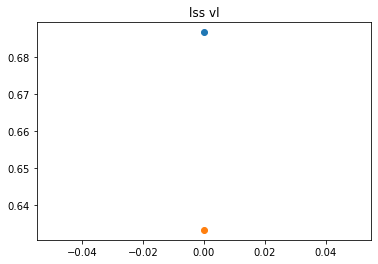

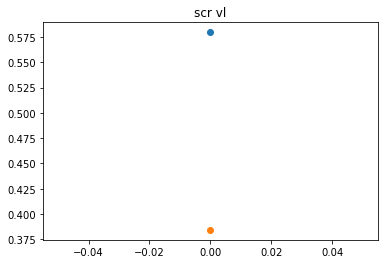

In [23]:
for k,v in stats.items():
    for tv,vs in v.items():
        plt.title(f'{k} {tv}')
        plt.plot(vs, 'o--')
    plt.show()

In [24]:
stats['best_scr'] = best_scr
stats['best_epc'] = best_epc

results = {}
results['fld2trvl'] = fld2trvl
results['oof'] = oof
results['stats'] = stats
resutls['param'] = param
pickle.dump(results, open(f'{p_out}/results.p', 'wb'))

# inference

In [21]:
dftst = pd.read_csv(f'{p_cmp}/test.csv', nrows=512 if param.DEBUG else None) 
dfsub = pd.read_csv(f'{p_cmp}/sample_submission.csv', nrows=512 if param.DEBUG else None) 
dftst['im_pth']=f'{p_cmp}/jpeg/test/'+dftst.image_name+'.jpg'

dstst = MelDataset(dftst, istrn=False)
print(len(dstst))
dltst = DataLoader(dstst, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
print(len(dltst))
lendl=len(dltst)

512
2


In [10]:
mdl = mkmdl()
# mdl.load_state_dict(torch.load(f'{p_out}/model_{param.PRFX}_fld_{param.FLD2USE}_best.p', map_location=torch.device(DEVICE)))

Loaded pretrained weights for efficientnet-b1


In [11]:
mdl = mdl.to(device)

In [ ]:
dstr = MelDataset(dftr)
dsvl = MelDataset(dfvl)
print(len(dstr), len(dsvl))
dltr = DataLoader(dstr, batch_size=param.BS,   shuffle=True,  num_workers=N_WORKERS, pin_memory=PIN_MEM)
dlvl = DataLoader(dsvl, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)


In [23]:
dstst[0][0]

tensor([[[1.8550, 1.7523, 1.5982,  ..., 1.7352, 1.7352, 1.6838],
         [1.8722, 1.8893, 1.8208,  ..., 1.6667, 1.7352, 1.7352],
         [1.8550, 1.8893, 1.8893,  ..., 1.3927, 1.5639, 1.6667],
         ...,
         [1.9749, 1.9749, 1.9578,  ..., 1.0502, 0.7933, 1.1700],
         [1.9578, 1.9407, 1.9407,  ..., 0.8789, 1.1015, 1.3242],
         [1.9407, 1.9064, 1.9235,  ..., 0.9303, 1.3070, 1.3755]],

        [[1.4307, 1.3081, 1.1681,  ..., 1.3256, 1.3431, 1.2906],
         [1.4482, 1.4657, 1.4132,  ..., 1.2906, 1.3782, 1.3431],
         [1.4307, 1.4657, 1.4657,  ..., 0.9580, 1.1506, 1.2731],
         ...,
         [1.5882, 1.5882, 1.5707,  ..., 0.4853, 0.2752, 0.7654],
         [1.5182, 1.5007, 1.5007,  ..., 0.3803, 0.6604, 0.9230],
         [1.5007, 1.4657, 1.4832,  ..., 0.4328, 0.8704, 0.9405]],

        [[1.7337, 1.5420, 1.2980,  ..., 1.5594, 1.5594, 1.5071],
         [1.7511, 1.7685, 1.6640,  ..., 1.5245, 1.6117, 1.5594],
         [1.7163, 1.7511, 1.7511,  ..., 0.9668, 1.2980, 1.

In [24]:
dltst

In [25]:
for foo in dltst:
    foo
    break

In [26]:
foo

[tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
           [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
           [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
           ...,
           [ 2.1804,  2.0605,  1.9749,  ...,  2.2489,  2.2489,  2.2489],
           [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
           [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489]],
 
          [[ 1.4132,  1.4132,  1.4482,  ...,  1.5882,  1.5707,  1.5882],
           [ 1.4132,  1.4132,  1.4482,  ...,  1.5882,  1.5707,  1.5882],
           [ 1.4482,  1.4482,  1.4657,  ...,  1.5882,  1.6057,  1.6232],
           ...,
           [ 1.3782,  1.3081,  1.1856,  ...,  1.7283,  1.7283,  1.7108],
           [ 1.5532,  1.5707,  1.5882,  ...,  1.7983,  1.7458,  1.6933],
           [ 1.6057,  1.6057,  1.6408,  ...,  1.7633,  1.7458,  1.6933]],
 
          [[ 1.7860,  1.7685,  1.7511,  ...,  1.8208,  1.8208,  1.8731],
           [ 

In [27]:
foo[0]

tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [ 2.1804,  2.0605,  1.9749,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489]],

         [[ 1.4132,  1.4132,  1.4482,  ...,  1.5882,  1.5707,  1.5882],
          [ 1.4132,  1.4132,  1.4482,  ...,  1.5882,  1.5707,  1.5882],
          [ 1.4482,  1.4482,  1.4657,  ...,  1.5882,  1.6057,  1.6232],
          ...,
          [ 1.3782,  1.3081,  1.1856,  ...,  1.7283,  1.7283,  1.7108],
          [ 1.5532,  1.5707,  1.5882,  ...,  1.7983,  1.7458,  1.6933],
          [ 1.6057,  1.6057,  1.6408,  ...,  1.7633,  1.7458,  1.6933]],

         [[ 1.7860,  1.7685,  1.7511,  ...,  1.8208,  1.8208,  1.8731],
          [ 1.7860,  1.7860,  

In [18]:
model=mdl
dl=dltst

In [28]:
    mdl.eval()
    prd = []
    for step, dat in enumerate(dl):
        if step%1000==0: print(dtnow(), f'step {step}/{lendl}')
        xb=dat[0].to(device)
        with torch.no_grad():
            prdb = mdl(xb)
        prd.append(prdb.cpu().detach().numpy())
    prd = np.concatenate(prd)    


KeyboardInterrupt: 

In [29]:
def infer(model, dl):
    lendl=len(dl)
    model.eval()
    prd = []
    for step, dat in enumerate(dl):
        if step%1000==0: print(dtnow(), f'step {step}/{lendl}')
        xb=dat[0].to(device)
        with torch.no_grad(): prdb = model(xb)
        prd.append(prdb.cpu().detach().numpy())
    prd = np.concatenate(prd)    
    return prd

In [ ]:
prdtst = infer(mdl, dltst)

# fin

In [ ]:
print(f'best_scr {best_scr:.4f}')

In [ ]:
param.__dict__

In [ ]:
!nvidia-smi